In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings

%matplotlib inline
## make sure the plot is included as one part of the code, otherwise plots can be shown in a seperate window
## import all required modules for future use

In [2]:
user_stat=pd.read_csv('user_table.csv',index_col=False)
test_stat=pd.read_csv('test_results.csv',index_col=False)

In [3]:
print(user_stat.describe())
print(test_stat.describe())
#summarize the user_stat information#

             user_id            lat           long
count  275616.000000  275616.000000  275616.000000
mean   499245.801521      37.111680     -93.981772
std    288533.458944       5.209627      18.086486
min         3.000000      19.700000    -157.800000
25%    249544.500000      33.660000    -112.200000
50%    498861.000000      37.740000     -88.930000
75%    748856.500000      40.700000     -78.910000
max    999999.000000      61.180000      30.310000
              user_id           test          price      converted
count   316800.000000  316800.000000  316800.000000  316800.000000
mean    499281.341840       0.360079      46.205051       0.018333
std     288591.154044       0.480024       9.601487       0.134154
min          3.000000       0.000000      39.000000       0.000000
25%     249525.750000       0.000000      39.000000       0.000000
50%     499021.500000       0.000000      39.000000       0.000000
75%     749025.500000       1.000000      59.000000       0.000000
max  

In [4]:
# Check uniqueness
print('Test ID:\t', len(test_stat['user_id'].unique()), '\t', len(test_stat['user_id'].unique()) == len(test_stat))
print('User ID:\t', len(user_stat['user_id'].unique()), '\t', len(user_stat['user_id'].unique()) == len(user_stat))

Test ID:	 316800 	 True
User ID:	 275616 	 True


In [5]:
print(user_stat[:5])
print(test_stat[:5])

   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68
   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted  
0     0     39          0  
1     0     39          0  
2     0     39          0  
3     1     59          0  
4     0     39          0  


In [6]:
print(user_stat['country'].value_counts())
print(user_stat['city'].value_counts())
print(user_stat['city'].value_counts().loc[lambda x : x>500])

USA    275616
Name: country, dtype: int64
New York       25748
Chicago         7153
Houston         6706
San Antonio     4633
Los Angeles     4141
               ...  
Cerritos           1
Costa Mesa         1
East Lake          1
New Milford        1
Ocala              1
Name: city, Length: 923, dtype: int64
New York       25748
Chicago         7153
Houston         6706
San Antonio     4633
Los Angeles     4141
               ...  
Canton           531
Providence       530
Anchorage        522
Toledo           505
Toms River       502
Name: city, Length: 104, dtype: int64


In [7]:
user_test = pd.merge(user_stat,test_stat, on='user_id', how='outer')

In [8]:
user_test.dropna(how='all')

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted
0,510335,Peabody,USA,42.53,-70.97,2015-05-02 12:06:41,ads-google,mobile,android,0,39,0
1,89568,Reno,USA,39.54,-119.82,2015-04-30 16:02:01,ads_facebook,mobile,android,1,59,0
2,434134,Rialto,USA,34.11,-117.39,2015-05-16 19:53:40,direct_traffic,web,windows,1,59,0
3,289769,Carson City,USA,39.15,-119.74,2015-04-23 18:50:58,ads_facebook,web,windows,0,39,0
4,939586,Chicago,USA,41.84,-87.68,2015-03-08 13:53:10,ads_facebook,mobile,iOS,1,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...
316795,622567,NaN,NaN,NaN,NaN,2015-04-09 21:54:09,direct_traffic,web,windows,0,39,0
316796,300043,NaN,NaN,NaN,NaN,2015-03-07 11:24:16,ads-google,web,windows,0,39,0
316797,590087,NaN,NaN,NaN,NaN,2015-03-13 11:30:09,ads_other,mobile,android,0,39,0
316798,874512,NaN,NaN,NaN,NaN,2015-03-14 12:13:52,ads_facebook,web,windows,0,39,0


In [23]:
# Problem with the data: test and price not match
user_test[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

It seems there are some problems with the data\
. there are a small amount of users who are labelled with test=0 but actually see price 59.\
. there are a small amount of users who are labelled with test=1 but actually see price 39.

In [26]:
# only keep the valid data
user_test = user_test[((user_test['test']==0) & (user_test['price']==39)) | ((user_test['test']==1) & (user_test['price']==59))]

In [27]:
# create new column called `revenue`
user_test['revenue'] = user_test['converted'] * user_test['price']

In [28]:
user_test.isnull().sum()

user_id                 0
city                41141
country             41141
lat                 41141
long                41141
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
revenue                 0
dtype: int64

In [75]:
c_group=user_test[user_test['test']==0]
t_group=user_test[user_test['test']==1]
print(c_group['revenue'].mean())
print(t_group['revenue'].mean())

0.7760829955016122
0.917747853719342


In [10]:
c_source=c_group['source'].unique()
t_source=t_group['source'].unique()
## get the source names from each group and store them as lists, it will allow us to group results based on the source tunnels.

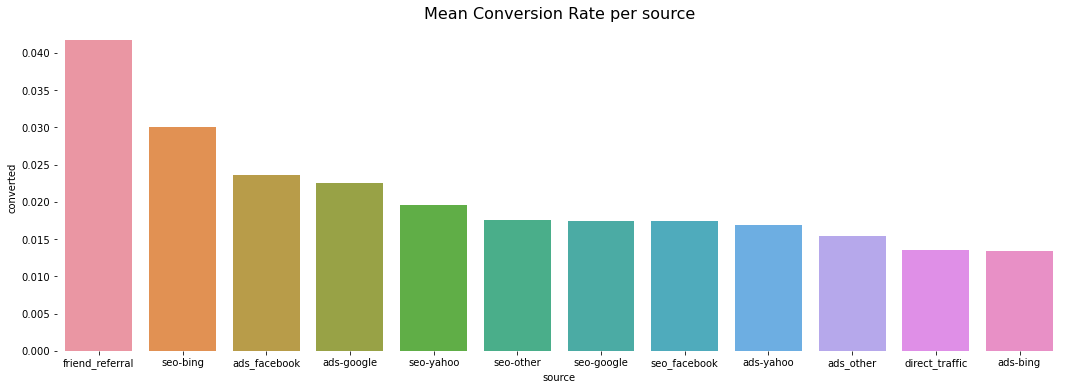

In [100]:
groupby_source = c_group.groupby('source')[['converted', 'source']].mean()
groupby_source = groupby_source.reset_index()
groupby_source = groupby_source.sort_values('converted', ascending=False)

## visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='source', y='converted', data=groupby_source, ax=ax)
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.set_title('Mean Conversion Rate per source', fontsize=16)
plt.show()

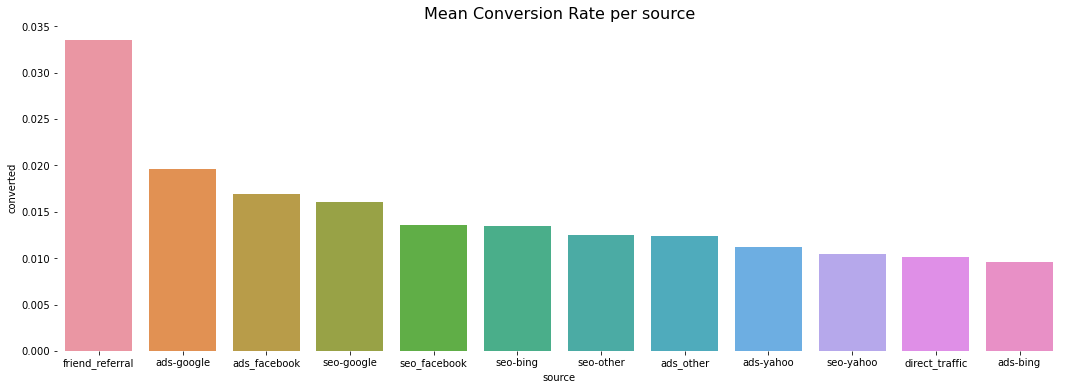

In [103]:
groupby_source = t_group.groupby('source')[['converted', 'source']].mean()
groupby_source = groupby_source.reset_index()
groupby_source = groupby_source.sort_values('converted', ascending=False)

## visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='source', y='converted', data=groupby_source, ax=ax)
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.set_title('Mean Conversion Rate per source', fontsize=16)
plt.show()

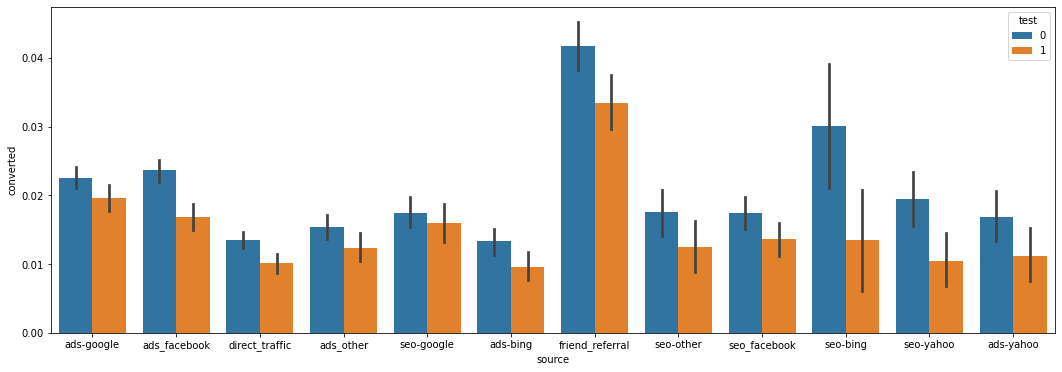

In [104]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='source', y='converted', hue='test', data=user_test, ax=ax)
plt.show()

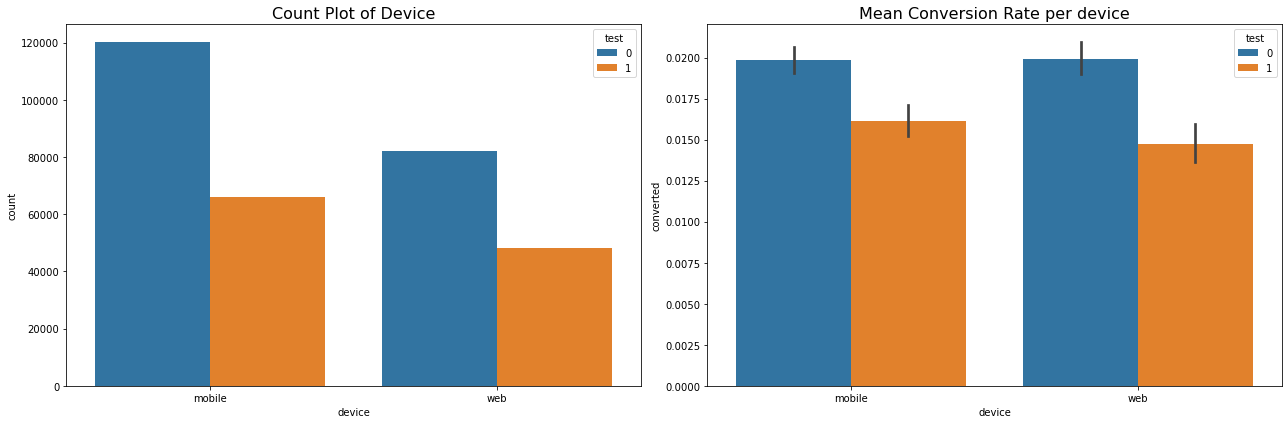

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=user_test, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='converted', hue='test', data=user_test, ax=ax[1]) ## specify the parameter in the dataframe, hue for different categories.
ax[1].set_title('Mean Conversion Rate per device', fontsize=16)
plt.tight_layout()
plt.show()

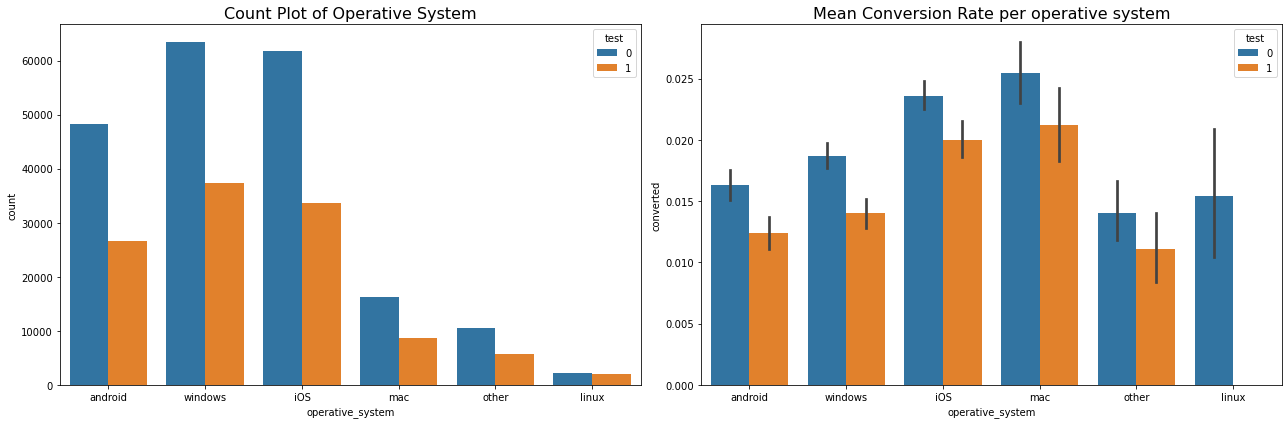

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='operative_system', hue='test', data=user_test, ax=ax[0])
ax[0].set_title('Count Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='converted', hue='test', data=user_test, ax=ax[1]) ## specify the parameter in the dataframe, hue for different categories.
ax[1].set_title('Mean Conversion Rate per operative system', fontsize=16)
plt.tight_layout()
plt.show()

# Q1

In [94]:
# check the conversion rate for A/B test
user_test[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [95]:
# check the revenue for A/B test
user_test[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Apparently, the mean conversion rate with price 39 is higher than the rate of price 59, but revenue with price 59 is higher than that of price 39. We can conduct an hypothesis testing to check if the mean revenue in test group is significantly higher than the mean revenue in the control group. \
Null Hypothesis: mean revenue is the same on both groups.\
Alternative Hypothesis: mean revenue in test group is higher. 

In [96]:
ctr_val = user_test[user_test['test'] == 0]['revenue'].values
exp_val = user_test[user_test['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463109, pvalue=1.0972577312420708e-08)


The above is a two-tailed test. However, even if it is one-tailed test, we can safely reject the null hypothesis to conclude that the mean revenue in test group is higher than the mean revenue in control group. Therefore, based on the statistical analysis of the mean revenue in both groups, teh company should sell the software for 59. 

# Q2

The holistic view into user behavior demands a look-up on each individual factor's relationship with the mean conversion rate in both groups. As we can see from the mean conversion rate per source, it is obvious the mean conversion rate with friend's referral is way higher the rest of sources. It sends us the message that adversting on old customers will be a good stratgy for the marketing team. In addition to that, mac or ios users have higher conversion rate than the rest of other operative systems. 
It's worth targeting ios and mac users for the marketing team. Also, simiarly, we can conduct a hypotheis testing to test if the mean conversion rate in control group is higher than that in experimental group. \
Null Hypothesis: mean conversion rate is the same on both groups.\
Alternative Hypothesis: mean conversion rate in control group is higher. 

In [108]:
ctr_rate = user_test[user_test['test'] == 0]['converted'].values
exp_rate = user_test[user_test['test'] == 1]['converted'].values
print(ttest_ind(ctr_rate, exp_rate, axis=0, equal_var=False))

Ttest_indResult(statistic=9.044608417898376, pvalue=1.5119397664466364e-19)


p-value is less than the level of significance 0.05 by default, there is statistical significant evidence that the mean conversion rate in control group is higher than the mean conversion rate in test group. ***In summary, lowering the price, targeting the old customers, advertising on ios and mac users will be three actionable strategies to imporve the conversion rate based on the study. ***

# Bonus

I personally disagree with his initution. If we run the experiment in a shorter time, the sample we collected might not reflect the true behvior of population. The result drawn from the new version of experient is subject to the sampling bias, making our decision making biased. 